In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import json
import random
import string
import math
import os
import requests
class CipherGenerator:
    def __init__(self):
        self.alphabet = string.ascii_lowercase
        corpus_path = 'corpus.txt'


        if not os.path.exists(corpus_path):
            print(f"Corpus file '{corpus_path}' not found. Downloading...")
            try:
                url = "https://www.gutenberg.org/files/1661/1661-0.txt"
                response = requests.get(url)
                response.raise_for_status()
                with open(corpus_path, 'w', encoding='utf-8') as f:
                    f.write(response.text)
                print("Download complete.")
            except requests.exceptions.RequestException as e:
                print(f"Error downloading corpus: {e}")
                print("Falling back to the simple default corpus.")
                self.plaintext_corpus = "the quick brown fox jumps over the lazy dog crypto is fun transformers are powerful".split() * 200
                return

        with open(corpus_path, 'r', encoding='utf-8') as f:
            text = f.read().lower()
            clean_text = ''.join(filter(lambda x: x in self.alphabet + ' ', text))
            self.plaintext_corpus = clean_text.split()
            print(f"Loaded a corpus with {len(self.plaintext_corpus)} words.")

    def _get_plaintext(self, min_len=15, max_len=50):
        num_words = random.randint(min_len, max_len)
        words = random.choices(self.plaintext_corpus, k=num_words)
        text = ' '.join(words)
        return ''.join(filter(lambda x: x in self.alphabet + ' ', text))

    def monoalphabetic_encrypt(self, plaintext):
        key = list(self.alphabet); random.shuffle(key)
        key_map = dict(zip(self.alphabet, key)); key_map[' '] = ' '
        ciphertext = "".join([key_map.get(char, char) for char in plaintext])
        return ciphertext, json.dumps(key_map)

    def polyalphabetic_encrypt(self, plaintext):
        key_len = random.randint(3, 10); key = "".join(random.choices(self.alphabet, k=key_len))
        ciphertext = ""; key_index = 0
        for char in plaintext:
            if char in self.alphabet:
                shift = self.alphabet.index(key[key_index]); char_index = self.alphabet.index(char)
                cipher_char_index = (char_index + shift) % 26; ciphertext += self.alphabet[cipher_char_index]
                key_index = (key_index + 1) % len(key)
            else: ciphertext += char
        return ciphertext, key

    def polymeric_encrypt(self, plaintext):
        intermediate_text, vigenere_key = self.polyalphabetic_encrypt(plaintext)
        key_len = random.randint(4, 8); transposition_key = "".join(random.sample(self.alphabet[:key_len], key_len))
        num_cols = len(transposition_key); num_rows = int(np.ceil(len(intermediate_text) / num_cols))
        padded_text = intermediate_text.ljust(num_rows * num_cols); grid = [list(padded_text[i:i+num_cols]) for i in range(0, len(padded_text), num_cols)]
        sorted_key = sorted(transposition_key); read_order = [transposition_key.index(k) for k in sorted_key]
        ciphertext = ""
        for col_idx in read_order:
            for row_idx in range(num_rows): ciphertext += grid[row_idx][col_idx]
        return ciphertext.strip(), json.dumps({"vigenere_key": vigenere_key, "transposition_key": transposition_key})

    def generate_data(self, num_samples_per_type):
        data = []
        total_samples = num_samples_per_type * 3
        count = 0

        for cipher_type in range(3):
            print(f"\n--- Generating {num_samples_per_type} samples for cipher type {cipher_type} ---")
            for _ in range(num_samples_per_type):
                plaintext = self._get_plaintext()
                if cipher_type == 0:
                    ciphertext, key = self.monoalphabetic_encrypt(plaintext)
                    label = 0
                elif cipher_type == 1:
                    ciphertext, key = self.polyalphabetic_encrypt(plaintext)
                    label = 1
                else:
                    ciphertext, key = self.polymeric_encrypt(plaintext)
                    label = 2

                data.append({"ciphertext": ciphertext, "cipher_type": label})
                count += 1
                if count % 1000 == 0:
                    print(f"Generated {count}/{total_samples} samples...")
        return data

print("Initializing generator...")
generator = CipherGenerator()


num_per_type = 10000
cipher_data = generator.generate_data(num_samples_per_type=num_per_type)
print(f"\nDataset with {len(cipher_data)} samples generated.")


class CipherDataset(Dataset):
    def __init__(self, data, vocab, max_len=256): self.vocab = vocab; self.max_len = max_len; self.data = data
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        item = self.data[idx]; ciphertext = item['ciphertext']; label = item['cipher_type']
        tokens = [self.vocab.get(char, self.vocab['<unk>']) for char in ciphertext]
        if len(tokens) < self.max_len: tokens.extend([self.vocab['<pad>']] * (self.max_len - len(tokens)))
        else: tokens = tokens[:self.max_len]
        return torch.tensor(tokens), torch.tensor(label)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__(); self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model); position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term); pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1); self.register_buffer('pe', pe)
    def forward(self, x): x = x + self.pe[:x.size(0), :]; return self.dropout(x)

class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_encoder_layers, dim_feedforward, num_classes, max_len):
        super(TransformerClassifier, self).__init__(); self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model); self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout=0.1, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        self.classifier = nn.Linear(d_model, num_classes); self.init_weights()
    def init_weights(self):
        initrange = 0.1; self.embedding.weight.data.uniform_(-initrange, initrange)
        self.classifier.bias.data.zero_(); self.classifier.weight.data.uniform_(-initrange, initrange)
    def forward(self, src):
        src_key_padding_mask = (src == 0); src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_key_padding_mask=src_key_padding_mask)
        output = output.mean(dim=1); return self.classifier(output)


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, checkpoint_path, start_epoch=0):
    model.to(device)
    print("\n--- Starting Training ---")
    for epoch in range(start_epoch, num_epochs):
        model.train()
        total_loss, correct_predictions, total_predictions = 0, 0, 0
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad(); outputs = model(texts); loss = criterion(outputs, labels)
            loss.backward(); optimizer.step()
            total_loss += loss.item(); _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0); correct_predictions += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_predictions / total_predictions
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {total_loss/len(train_loader):.4f} | Train Acc: {train_accuracy:.2f}% | LR: {current_lr:.6f}")

        model.eval()
        val_loss, correct_predictions, total_predictions = 0, 0, 0
        with torch.no_grad():
            for texts, labels in val_loader:
                texts, labels = texts.to(device), labels.to(device)
                outputs = model(texts); val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1); total_predictions += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

        val_accuracy = 100 * correct_predictions / total_predictions
        print(f"Epoch {epoch+1}/{num_epochs} | Valid Loss: {val_loss/len(val_loader):.4f} | Valid Acc: {val_accuracy:.2f}%")


        checkpoint = {'epoch': epoch + 1, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")
    print("--- Training Finished ---")
    return model

VOCAB = {char: i+1 for i, char in enumerate("abcdefghijklmnopqrstuvwxyz ")}
VOCAB['<pad>'] = 0; VOCAB['<unk>'] = len(VOCAB)

VOCAB_SIZE = len(VOCAB)
D_MODEL = 256
NHEAD = 8
NUM_ENCODER_LAYERS = 6
DIM_FEEDFORWARD = 1024
MAX_LEN = 256
NUM_CLASSES = 3
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 0.0001

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
CHECKPOINT_PATH = "cipher_model_checkpoint_v3.pth"

full_dataset = CipherDataset(cipher_data, VOCAB, MAX_LEN)
train_size = int(0.8 * len(full_dataset)); val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True); val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

model = TransformerClassifier(VOCAB_SIZE, D_MODEL, NHEAD, NUM_ENCODER_LAYERS, DIM_FEEDFORWARD, NUM_CLASSES, MAX_LEN)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


start_epoch = 0
if os.path.exists(CHECKPOINT_PATH):
    print(f"Checkpoint found! Loading from {CHECKPOINT_PATH}")
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict']); optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    if start_epoch >= NUM_EPOCHS: print("Training has already completed.")
    else: print(f"Resuming training from epoch {start_epoch + 1}")
else: print("No checkpoint found, starting training from scratch.")

if start_epoch < NUM_EPOCHS:
    trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, DEVICE, CHECKPOINT_PATH, start_epoch)
else:
    model.to(DEVICE); trained_model = model

def predict_cipher(ciphertext, model, vocab, max_len, device):
    model.eval()
    tokens = [vocab.get(char, vocab['<unk>']) for char in ciphertext]
    if len(tokens) < max_len: tokens.extend([vocab['<pad>']] * (max_len - len(tokens)))
    else: tokens = tokens[:max_len]
    input_tensor = torch.tensor([tokens]).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)
    return predicted_class.item(), confidence.item()

print("\n--- Running Predictions ---")
cipher_map = {0: "Monoalphabetic", 1: "Polyalphabetic", 2: "Polymeric"}
try:
    random.shuffle(cipher_data)
    mono_sample = next(item for item in cipher_data if item["cipher_type"] == 0)
    poly_sample = next(item for item in cipher_data if item["cipher_type"] == 1)
    polymeric_sample = next(item for item in cipher_data if item["cipher_type"] == 2)
    test_samples = [mono_sample, poly_sample, polymeric_sample]

    for sample in test_samples:
        test_ciphertext = sample['ciphertext']
        true_label = sample['cipher_type']
        predicted_label, confidence = predict_cipher(test_ciphertext, trained_model, VOCAB, MAX_LEN, DEVICE)
        print("-" * 30)
        print(f"Ciphertext:      '{test_ciphertext[:60]}...'")
        print(f"True Type:       {cipher_map[true_label]}")
        print(f"Predicted Type:  {cipher_map[predicted_label]} (Confidence: {confidence:.2%})")
        print(f"Result:          {'Correct' if predicted_label == true_label else 'Incorrect'}")
except StopIteration:
    print("Could not find a sample for each cipher type to run prediction.")

Initializing generator...
Corpus file 'corpus.txt' not found. Downloading...
Download complete.
Loaded a corpus with 97918 words.

--- Generating 10000 samples for cipher type 0 ---
Generated 1000/30000 samples...
Generated 2000/30000 samples...
Generated 3000/30000 samples...
Generated 4000/30000 samples...
Generated 5000/30000 samples...
Generated 6000/30000 samples...
Generated 7000/30000 samples...
Generated 8000/30000 samples...
Generated 9000/30000 samples...
Generated 10000/30000 samples...

--- Generating 10000 samples for cipher type 1 ---
Generated 11000/30000 samples...
Generated 12000/30000 samples...
Generated 13000/30000 samples...
Generated 14000/30000 samples...
Generated 15000/30000 samples...
Generated 16000/30000 samples...
Generated 17000/30000 samples...
Generated 18000/30000 samples...
Generated 19000/30000 samples...
Generated 20000/30000 samples...

--- Generating 10000 samples for cipher type 2 ---
Generated 21000/30000 samples...
Generated 22000/30000 samples.

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Epoch 1/20 | Valid Loss: 0.9433 | Valid Acc: 51.68%
Checkpoint saved to cipher_model_checkpoint_v3.pth
Epoch 2/20 | Train Loss: 0.7868 | Train Acc: 57.77% | LR: 0.000100
Epoch 2/20 | Valid Loss: 0.7511 | Valid Acc: 57.75%
Checkpoint saved to cipher_model_checkpoint_v3.pth
Epoch 3/20 | Train Loss: 0.6624 | Train Acc: 61.94% | LR: 0.000100
Epoch 3/20 | Valid Loss: 0.6749 | Valid Acc: 60.02%
Checkpoint saved to cipher_model_checkpoint_v3.pth
Epoch 4/20 | Train Loss: 0.5878 | Train Acc: 65.05% | LR: 0.000100
Epoch 4/20 | Valid Loss: 0.6233 | Valid Acc: 63.70%
Checkpoint saved to cipher_model_checkpoint_v3.pth
Epoch 5/20 | Train Loss: 0.5503 | Train Acc: 66.93% | LR: 0.000100
Epoch 5/20 | Valid Loss: 0.5816 | Valid Acc: 64.92%
Checkpoint saved to cipher_model_checkpoint_v3.pth
Epoch 6/20 | Train Loss: 0.5223 | Train Acc: 69.19% | LR: 0.000100
Epoch 6/20 | Valid Loss: 0.5897 | Valid Acc: 63.58%
Checkpoint saved to cipher_model_checkpoint_v3.pth
Epoch 7/20 | Train Loss: 0.5188 | Train Acc: 68

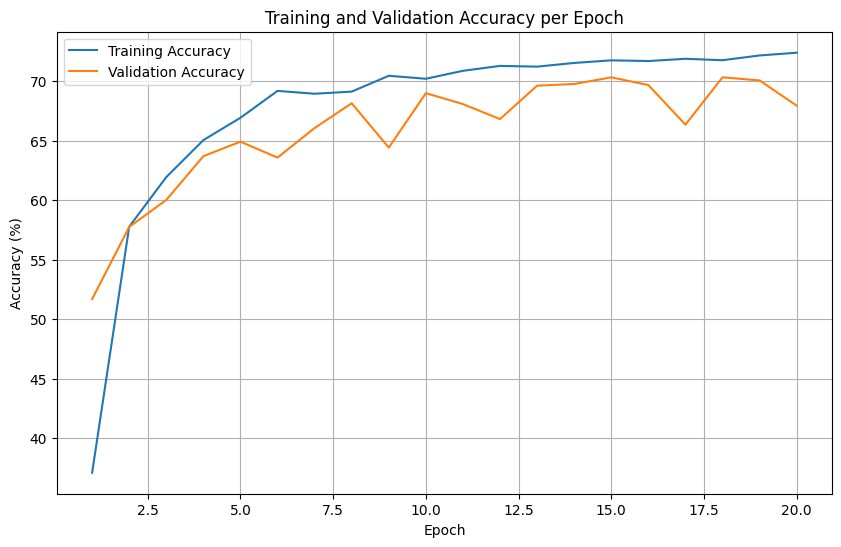

In [ ]:
import matplotlib.pyplot as plt
import re

# Extract accuracy values from the output
output = """
Initializing generator...
Corpus file 'corpus.txt' not found. Downloading...
Download complete.
Loaded a corpus with 97918 words.

--- Generating 10000 samples for cipher type 0 ---
Generated 1000/30000 samples...
Generated 2000/30000 samples...
Generated 3000/30000 samples...
Generated 4000/30000 samples...
Generated 5000/30000 samples...
Generated 6000/30000 samples...
Generated 7000/30000 samples...
Generated 8000/30000 samples...
Generated 9000/30000 samples...
Generated 10000/30000 samples...

--- Generating 10000 samples for cipher type 1 ---
Generated 11000/30000 samples...
Generated 12000/30000 samples...
Generated 13000/30000 samples...
Generated 14000/30000 samples...
Generated 15000/30000 samples...
Generated 16000/30000 samples...
Generated 17000/30000 samples...
Generated 18000/30000 samples...
Generated 19000/30000 samples...
Generated 20000/30000 samples...

--- Generating 10000 samples for cipher type 2 ---
Generated 21000/30000 samples...
Generated 22000/30000 samples...
Generated 23000/30000 samples...
Generated 24000/30000 samples...
Generated 25000/30000 samples...
Generated 26000/30000 samples...
Generated 27000/30000 samples...
Generated 28000/30000 samples...
Generated 29000/30000 samples...
Generated 30000/30000 samples...

Dataset with 30000 samples generated.
Using device: cuda
No checkpoint found, starting training from scratch.

--- Starting Training ---
Epoch 1/20 | Train Loss: 1.0937 | Train Acc: 37.08% | LR: 0.000100

Epoch 1/20 | Valid Loss: 0.9433 | Valid Acc: 51.68%
Checkpoint saved to cipher_model_checkpoint_v3.pth
Epoch 2/20 | Train Loss: 0.7868 | Train Acc: 57.77% | LR: 0.000100
Epoch 2/20 | Valid Loss: 0.7511 | Valid Acc: 57.75%
Checkpoint saved to cipher_model_checkpoint_v3.pth
Epoch 3/20 | Train Loss: 0.6624 | Train Acc: 61.94% | LR: 0.000100
Epoch 3/20 | Valid Loss: 0.6749 | Valid Acc: 60.02%
Checkpoint saved to cipher_model_checkpoint_v3.pth
Epoch 4/20 | Train Loss: 0.5878 | Train Acc: 65.05% | LR: 0.000100
Epoch 4/20 | Valid Loss: 0.6233 | Valid Acc: 63.70%
Checkpoint saved to cipher_model_checkpoint_v3.pth
Epoch 5/20 | Train Loss: 0.5503 | Train Acc: 66.93% | LR: 0.000100
Epoch 5/20 | Valid Loss: 0.5816 | Valid Acc: 64.92%
Checkpoint saved to cipher_model_checkpoint_v3.pth
Epoch 6/20 | Train Loss: 0.5223 | Train Acc: 69.19% | LR: 0.000100
Epoch 6/20 | Valid Loss: 0.5897 | Valid Acc: 63.58%
Checkpoint saved to cipher_model_checkpoint_v3.pth
Epoch 7/20 | Train Loss: 0.5188 | Train Acc: 68.95% | LR: 0.000100
Epoch 7/20 | Valid Loss: 0.5988 | Valid Acc: 66.07%
Checkpoint saved to cipher_model_checkpoint_v3.pth
Epoch 8/20 | Train Loss: 0.5148 | Train Acc: 69.13% | LR: 0.000100
Epoch 8/20 | Valid Loss: 0.5582 | Valid Acc: 68.15%
Checkpoint saved to cipher_model_checkpoint_v3.pth
Epoch 9/20 | Train Loss: 0.4997 | Train Acc: 70.46% | LR: 0.000100
Epoch 9/20 | Valid Loss: 0.5614 | Valid Acc: 64.42%
Checkpoint saved to cipher_model_checkpoint_v3.pth
Epoch 10/20 | Train Loss: 0.4956 | Train Acc: 70.21% | LR: 0.000100
Epoch 10/20 | Valid Loss: 0.5585 | Valid Acc: 69.00%
Checkpoint saved to cipher_model_checkpoint_v3.pth
Epoch 11/20 | Train Loss: 0.4913 | Train Acc: 70.88% | LR: 0.000100
Epoch 11/20 | Valid Loss: 0.5599 | Valid Acc: 68.08%
Checkpoint saved to cipher_model_checkpoint_v3.pth
Epoch 12/20 | Train Loss: 0.4869 | Train Acc: 71.29% | LR: 0.000100
Epoch 12/20 | Valid Loss: 0.5386 | Valid Acc: 66.82%
Checkpoint saved to cipher_model_checkpoint_v3.pth
Epoch 13/20 | Train Loss: 0.4850 | Train Acc: 71.23% | LR: 0.000100
Epoch 13/20 | Valid Loss: 0.5489 | Valid Acc: 69.63%
Checkpoint saved to cipher_model_checkpoint_v3.pth
Epoch 14/20 | Train Loss: 0.4814 | Train Acc: 71.54% | LR: 0.000100
Epoch 14/20 | Valid Loss: 0.5358 | Valid Acc: 69.77%
Checkpoint saved to cipher_model_checkpoint_v3.pth
Epoch 15/20 | Train Loss: 0.4798 | Train Acc: 71.76% | LR: 0.000100
Epoch 15/20 | Valid Loss: 0.5468 | Valid Acc: 70.33%
Checkpoint saved to cipher_model_checkpoint_v3.pth
Epoch 16/20 | Train Loss: 0.4776 | Train Acc: 71.70% | LR: 0.000100
Epoch 16/20 | Valid Loss: 0.5628 | Valid Acc: 69.68%
Checkpoint saved to cipher_model_checkpoint_v3.pth
Epoch 17/20 | Train Loss: 0.4765 | Train Acc: 71.89% | LR: 0.000100
Epoch 17/20 | Valid Loss: 0.5679 | Valid Acc: 66.35%
Checkpoint saved to cipher_model_checkpoint_v3.pth
Epoch 18/20 | Train Loss: 0.4735 | Train Acc: 71.77% | LR: 0.000100
Epoch 18/20 | Valid Loss: 0.5431 | Valid Acc: 70.33%
Checkpoint saved to cipher_model_checkpoint_v3.pth
Epoch 19/20 | Train Loss: 0.4720 | Train Acc: 72.17% | LR: 0.000100
Epoch 19/20 | Valid Loss: 0.5561 | Valid Acc: 70.07%
Checkpoint saved to cipher_model_checkpoint_v3.pth
Epoch 20/20 | Train Loss: 0.4674 | Train Acc: 72.40% | LR: 0.000100
Epoch 20/20 | Valid Loss: 0.5637 | Valid Acc: 67.95%
Checkpoint saved to cipher_model_checkpoint_v3.pth
--- Training Finished ---

--- Running Predictions ---
------------------------------
Ciphertext:      'vtggh qlx qg vanbtkb qlxrmxtt xoxrbru maj cxqxhjvbxts lgijxj...'
True Type:       Monoalphabetic
Predicted Type:  Monoalphabetic (Confidence: 100.00%)
Result:          Correct
------------------------------
Ciphertext:      'xiyos tte jyq rngtt vuutj sauq ttixfauwyqawoxd mie tmoggmt e...'
True Type:       Polyalphabetic
Predicted Type:  Polyalphabetic (Confidence: 55.43%)
Result:          Correct
------------------------------
Ciphertext:      'fcjrzhfj yxfwbvmdjrnh  zclh fjbl bxnnrxrjurrtokyk kbjmugngyu...'
True Type:       Polymeric
Predicted Type:  Polyalphabetic (Confidence: 55.84%)
Result:          Incorrect
"""

train_acc = re.findall(r"Train Acc: (\d+\.\d+)", output)
val_acc = re.findall(r"Valid Acc: (\d+\.\d+)", output)

train_acc = [float(acc) for acc in train_acc]
val_acc = [float(acc) for acc in val_acc]
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()